In [1]:
# import library
import tensorflow as tf
import numpy as np
import sys, os,cv2
from scipy.misc import imread,imresize
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from imgaug import augmenters as iaa
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs,make_moons,make_swiss_roll

plt.style.use('seaborn')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

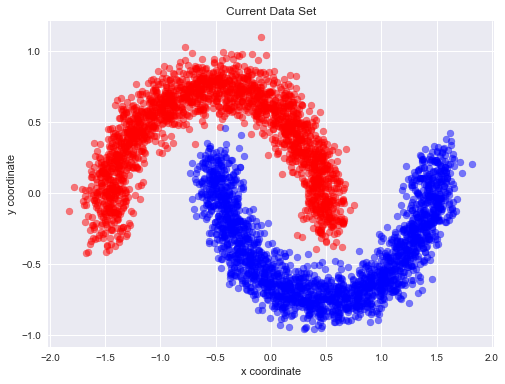

In [206]:
# load some data set
n_samples = 4000
X, y = make_moons(n_samples=n_samples, random_state=123,noise=0.1)
X    = X - X.mean(0,keepdims=True)
plt.figure(figsize=(8,6))
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
plt.title('Current Data Set'); plt.ylabel('y coordinate'); plt.xlabel('x coordinate'); plt.grid(True)
plt.show()

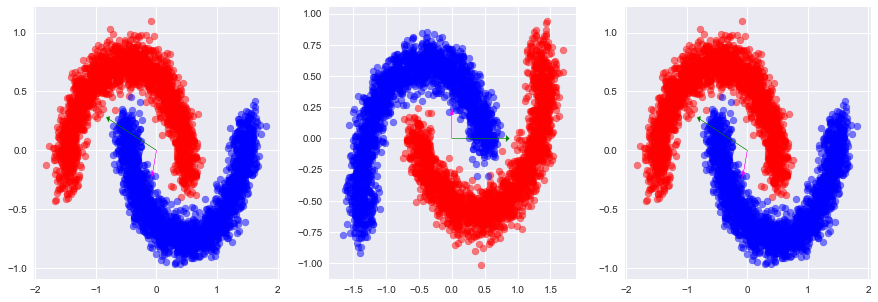

In [207]:
# Do EVD to see the projection matrix
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]
project_X  = X   @ vec;                      project_V  = vec.T @ vec
revert_X   = project_X @ np.linalg.inv(vec) ;revertedV  = project_V @ np.linalg.inv(vec).T

plt.figure(figsize=(15,5)); 

plt.subplot(131); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(132); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *project_V[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *project_V[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(133); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

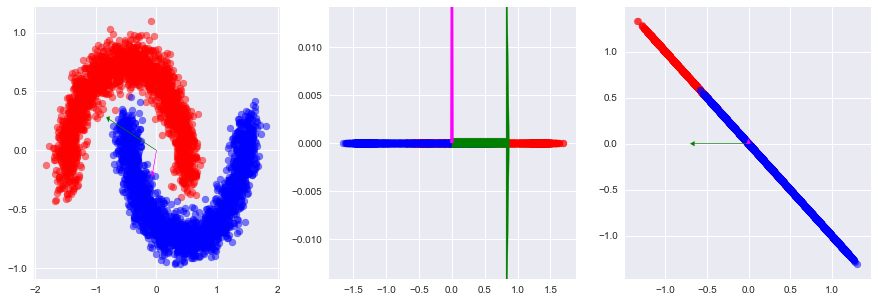

In [208]:
# perform D reduction
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]

vec_reduced= np.zeros_like(vec)
vec_reduced[:,:1] = vec[:,:1]
val_reduced= val.copy()
val_reduced[-1:]= 0

project_X  = X   @ vec_reduced;                      project_V  = vec_reduced.T @ vec_reduced
revert_X   = project_X @ np.linalg.inv(vec_reduced+0.0001) ;revertedV  = project_V.T @ np.linalg.inv(vec_reduced+0.0001)

plt.figure(figsize=(15,5)); 

plt.subplot(131); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(132); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *project_V[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *project_V[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(133); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

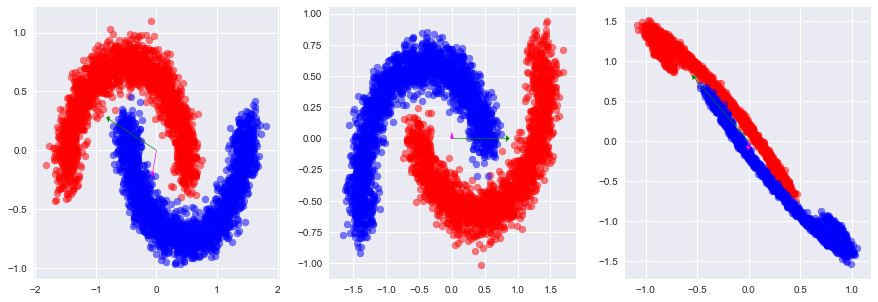

In [214]:
# do the reduction but in a different way
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]
project_X    = X   @ vec;                      project_V  = vec.T @ vec

inversed_vec  = np.linalg.inv(vec)
inversed_vec  = inversed_vec - inversed_vec.mean(1)
revert_X      = project_X @ inversed_vec ;revertedV  = project_V @ inversed_vec.T


def plot():
    plt.figure(figsize=(15,5)); 

    plt.subplot(131); 
    plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
    plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
    pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
    pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
    plt.grid(True); 

    plt.subplot(132); 
    plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
    plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
    pca21=plt.arrow   (0, 0, *project_V[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
    pca22=plt.arrow   (0, 0, *project_V[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
    plt.grid(True); 

    plt.subplot(133); 
    plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
    plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
    pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
    pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
    plt.grid(True); 

    plt.show()
plot()

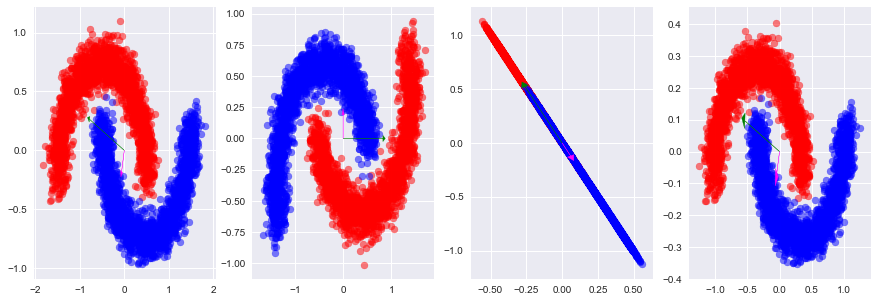

In [215]:
# Do EVD to see the projection matrix
cov        = X.T @ X /(X.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)
idx        = np.argsort(val)[::-1]; val = val[idx]; vec = vec[:,idx]
project_X  = X   @ vec;                      project_V  = vec.T @ vec

plt.figure(figsize=(15,5)); 

plt.subplot(141); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(142); 
plt.scatter(project_X[y==0, 0], project_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(project_X[y==1, 0], project_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *project_V[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *project_V[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

inverse  = np.linalg.inv(vec)
inverse  = inverse - inverse.mean(0,keepdims=True) 
revert_X   = project_X @ inverse ;revertedV  = project_V @ inverse.T

plt.subplot(143); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

inverse  = np.linalg.inv(vec)
inverse  = inverse - inverse*inverse.std(0,keepdims=True)
revert_X   = project_X @ inverse ;revertedV  = project_V @ inverse.T

plt.subplot(144); 
plt.scatter(revert_X[y==0, 0], revert_X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(revert_X[y==1, 0], revert_X[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *revertedV[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *revertedV[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

In [216]:
# kernel PCA
gamma = 100
sq_x  = -2 * X @ X.T + np.sum(X**2,1) + np.sum(X**2,1,keepdims=True)
K     = np.exp(-gamma * sq_x)
N     = K.shape[0]
one_n = np.ones((N,N)) / N
K2    = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
eigvals, eigvecs = np.linalg.eigh(K2)

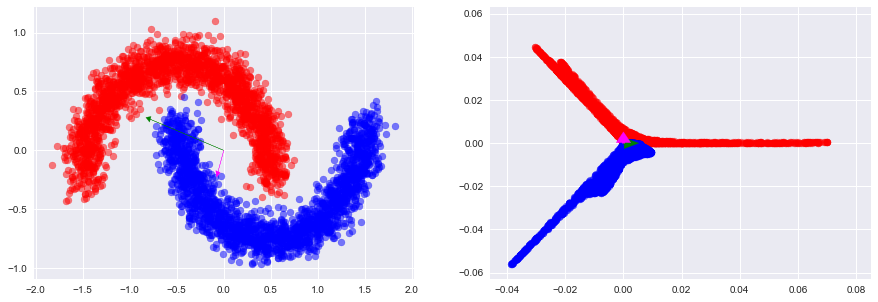

In [217]:
new_pc = eigvecs[:,-2:]

plt.figure(figsize=(15,5)); 

plt.subplot(121); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

new_pc_cen = new_pc - new_pc.mean(0,keepdims=True)
cov        = new_pc_cen.T @ new_pc_cen /(new_pc_cen.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)

plt.subplot(122); 
plt.scatter(new_pc[y==0, 0], new_pc[y==0, 1], color='red',  alpha=0.5)
plt.scatter(new_pc[y==1, 0], new_pc[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.005, head_length=0.005,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.005, head_length=0.005,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

In [218]:
# Spase PCA
import pywt

class SPC(object):
    
    def __init__(self, number_of_components,max_iter=10, threshold_val=1.5 ):
        
        
        """Initialize the SPC object
        
        Positional arguments:
        number_of_components -- the number of sparse principal components 
        to compute, must be between 1 and p (total number of features)
        
        Keyword argument:
        max_iter -- the number of iterations to perform (default=10)
        threshold_val -- value of the lambda regularisation 
        parameter (default=10)
        """
        self.number_of_components=number_of_components
        self.max_iter=max_iter
        self.threshold_val=threshold_val
    
    def fit(self, X_):
        """learn the sparse pc of a data matrix, return sparse estimates
        of the left and right singular vectors (U and V respectively) 
        as well as the standard principal components loading matrix W
    
        Positional arguments:
        X_ -- training data matrix, as numpy ndarray
        
        """ 
        print("computing sparse principal components...")
        print("computing SVD of data matrix...")
        U, s, V = np.linalg.svd(X_, full_matrices=True)  
        cnt = 0
        self.U = U
        self.W = V.T
        def normalize(vector):
            norm=np.linalg.norm(vector)
            if norm>0:
                return vector/norm
            else:
                return vector
        print("starting iterations...")
        while True:
           
            self.V = pywt.threshold(np.dot(U[:self.number_of_components],X_), self.threshold_val)
            self.U = np.dot(self.V,X_.T)
            self.U = np.array([normalize(u_i) for u_i in self.U])
            if cnt%2==0:
                print("{} out of {} iterations".format(cnt,self.max_iter))
            cnt += 1
            if cnt == self.max_iter:
                self.V = np.array([normalize(v_i) for v_i in self.V])
                break
        print("...finish")
        return self.U, self.V, self.W
    
    def transform(self, X_, k=2):
        X_reduced_spca     = np.dot(X_, np.dot(self.V[:k].T, self.V[:k]))
        return X_reduced_spca
my_spca  = SPC(2,3000,0.1)
my_spca.fit(X)

computing sparse principal components...
computing SVD of data matrix...
starting iterations...
0 out of 3000 iterations
2 out of 3000 iterations
4 out of 3000 iterations
6 out of 3000 iterations
8 out of 3000 iterations
10 out of 3000 iterations
12 out of 3000 iterations
14 out of 3000 iterations
16 out of 3000 iterations
18 out of 3000 iterations
20 out of 3000 iterations
22 out of 3000 iterations
24 out of 3000 iterations
26 out of 3000 iterations
28 out of 3000 iterations
30 out of 3000 iterations
32 out of 3000 iterations
34 out of 3000 iterations
36 out of 3000 iterations
38 out of 3000 iterations
40 out of 3000 iterations
42 out of 3000 iterations
44 out of 3000 iterations
46 out of 3000 iterations
48 out of 3000 iterations
50 out of 3000 iterations
52 out of 3000 iterations
54 out of 3000 iterations
56 out of 3000 iterations
58 out of 3000 iterations
60 out of 3000 iterations
62 out of 3000 iterations
64 out of 3000 iterations
66 out of 3000 iterations
68 out of 3000 iterations

802 out of 3000 iterations
804 out of 3000 iterations
806 out of 3000 iterations
808 out of 3000 iterations
810 out of 3000 iterations
812 out of 3000 iterations
814 out of 3000 iterations
816 out of 3000 iterations
818 out of 3000 iterations
820 out of 3000 iterations
822 out of 3000 iterations
824 out of 3000 iterations
826 out of 3000 iterations
828 out of 3000 iterations
830 out of 3000 iterations
832 out of 3000 iterations
834 out of 3000 iterations
836 out of 3000 iterations
838 out of 3000 iterations
840 out of 3000 iterations
842 out of 3000 iterations
844 out of 3000 iterations
846 out of 3000 iterations
848 out of 3000 iterations
850 out of 3000 iterations
852 out of 3000 iterations
854 out of 3000 iterations
856 out of 3000 iterations
858 out of 3000 iterations
860 out of 3000 iterations
862 out of 3000 iterations
864 out of 3000 iterations
866 out of 3000 iterations
868 out of 3000 iterations
870 out of 3000 iterations
872 out of 3000 iterations
874 out of 3000 iterations
8

1542 out of 3000 iterations
1544 out of 3000 iterations
1546 out of 3000 iterations
1548 out of 3000 iterations
1550 out of 3000 iterations
1552 out of 3000 iterations
1554 out of 3000 iterations
1556 out of 3000 iterations
1558 out of 3000 iterations
1560 out of 3000 iterations
1562 out of 3000 iterations
1564 out of 3000 iterations
1566 out of 3000 iterations
1568 out of 3000 iterations
1570 out of 3000 iterations
1572 out of 3000 iterations
1574 out of 3000 iterations
1576 out of 3000 iterations
1578 out of 3000 iterations
1580 out of 3000 iterations
1582 out of 3000 iterations
1584 out of 3000 iterations
1586 out of 3000 iterations
1588 out of 3000 iterations
1590 out of 3000 iterations
1592 out of 3000 iterations
1594 out of 3000 iterations
1596 out of 3000 iterations
1598 out of 3000 iterations
1600 out of 3000 iterations
1602 out of 3000 iterations
1604 out of 3000 iterations
1606 out of 3000 iterations
1608 out of 3000 iterations
1610 out of 3000 iterations
1612 out of 3000 ite

2426 out of 3000 iterations
2428 out of 3000 iterations
2430 out of 3000 iterations
2432 out of 3000 iterations
2434 out of 3000 iterations
2436 out of 3000 iterations
2438 out of 3000 iterations
2440 out of 3000 iterations
2442 out of 3000 iterations
2444 out of 3000 iterations
2446 out of 3000 iterations
2448 out of 3000 iterations
2450 out of 3000 iterations
2452 out of 3000 iterations
2454 out of 3000 iterations
2456 out of 3000 iterations
2458 out of 3000 iterations
2460 out of 3000 iterations
2462 out of 3000 iterations
2464 out of 3000 iterations
2466 out of 3000 iterations
2468 out of 3000 iterations
2470 out of 3000 iterations
2472 out of 3000 iterations
2474 out of 3000 iterations
2476 out of 3000 iterations
2478 out of 3000 iterations
2480 out of 3000 iterations
2482 out of 3000 iterations
2484 out of 3000 iterations
2486 out of 3000 iterations
2488 out of 3000 iterations
2490 out of 3000 iterations
2492 out of 3000 iterations
2494 out of 3000 iterations
2496 out of 3000 ite

(array([[-0.01356485,  0.00598375, -0.00657987, ...,  0.02192857,
          0.01975827,  0.0244038 ],
        [ 0.02543667, -0.01435941, -0.0064723 , ..., -0.02106813,
         -0.00923035, -0.01102696]]), array([[ 0.96735937, -0.25340845],
        [ 0.03304087,  0.999454  ]]), array([[ 0.94743336,  0.31995318],
        [-0.31995318,  0.94743336]]))

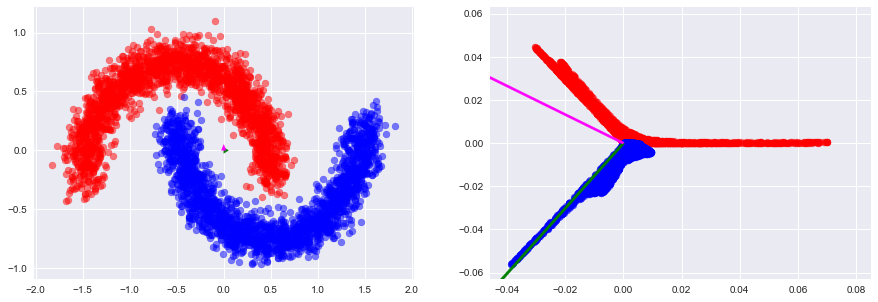

In [219]:
sparse_data = my_spca.transform(X)

plt.figure(figsize=(15,5)); 

plt.subplot(121); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

new_pc_cen = sparse_data - sparse_data.mean(0,keepdims=True)
cov        = new_pc_cen.T @ new_pc_cen /(new_pc_cen.shape[0] - 1)
val,vec    = np.linalg.eigh(cov)

plt.subplot(122); 
plt.scatter(new_pc[y==0, 0], new_pc[y==0, 1], color='red',  alpha=0.5)
plt.scatter(new_pc[y==1, 0], new_pc[y==1, 1], color='blue', alpha=0.5)
pca21=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.005, head_length=0.005,color='Green',  label='First PC')
pca22=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.005, head_length=0.005,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

In [220]:
# robust pca
from __future__ import division, print_function

import numpy as np

try:
    from pylab import plt
except ImportError:
    print('Unable to import pylab. R_pca.plot_fit() will not work.')

try:
    # Python 2: 'xrange' is the iterative version
    range = xrange
except NameError:
    # Python 3: 'range' is iterative - no need for 'xrange'
    pass


class R_pca:

    def __init__(self, D, mu=None, lmbda=None):
        self.D = D
        self.S = np.zeros(self.D.shape)
        self.Y = np.zeros(self.D.shape)

        if mu:
            self.mu = mu
        else:
            self.mu = np.prod(self.D.shape) / (4 * self.norm_p(self.D, 2))

        self.mu_inv = 1 / self.mu

        if lmbda:
            self.lmbda = lmbda
        else:
            self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

    @staticmethod
    def norm_p(M, p):
        return np.sum(np.power(M, p))

    @staticmethod
    def shrink(M, tau):
        return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

    def svd_threshold(self, M, tau):
        U, S, V = np.linalg.svd(M, full_matrices=False)
        return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

    def fit(self, tol=None, max_iter=1000, iter_print=100):
        iter = 0
        err = np.Inf
        Sk = self.S
        Yk = self.Y
        Lk = np.zeros(self.D.shape)

        if tol:
            _tol = tol
        else:
            _tol = 1E-7 * self.norm_p(np.abs(self.D), 2)

        while (err > _tol) and iter < max_iter:
            Lk = self.svd_threshold(
                self.D - Sk + self.mu_inv * Yk, self.mu_inv)
            Sk = self.shrink(
                self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)
            Yk = Yk + self.mu * (self.D - Lk - Sk)
            err = self.norm_p(np.abs(self.D - Lk - Sk), 2)
            iter += 1
            if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
                print('iteration: {0}, error: {1}'.format(iter, err))

        self.L = Lk
        self.S = Sk
        return Lk, Sk

    def plot_fit(self, size=None, tol=0.1, axis_on=True):

        n, d = self.D.shape

        if size:
            nrows, ncols = size
        else:
            sq = np.ceil(np.sqrt(n))
            nrows = int(sq)
            ncols = int(sq)

        ymin = np.nanmin(self.D)
        ymax = np.nanmax(self.D)
        print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

        numplots = np.min([n, nrows * ncols])
        plt.figure()

        for n in range(numplots):
            plt.subplot(nrows, ncols, n + 1)
            plt.ylim((ymin - tol, ymax + tol))
            plt.plot(self.L[n, :] + self.S[n, :], 'r')
            plt.plot(self.L[n, :], 'b')
            if not axis_on:
                plt.axis('off')

In [221]:
rpca = R_pca(X)
L, S = rpca.fit(max_iter=10000, iter_print=1)
print(L.shape)
print(S.shape)

iteration: 1, error: 4.637450205707501
iteration: 2, error: 0.0010999696697002858
iteration: 3, error: 0.00033011446100443114
(4000, 2)
(4000, 2)


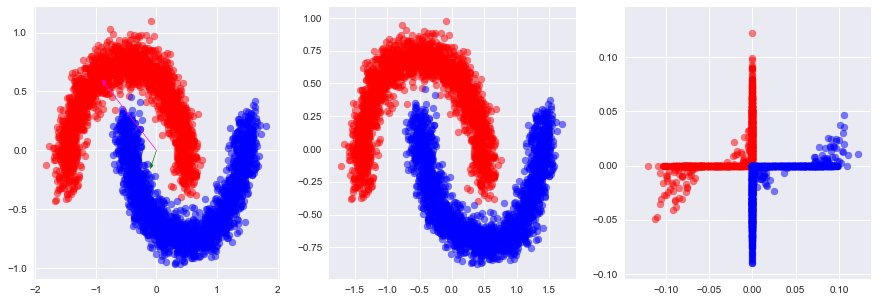

In [222]:
plt.figure(figsize=(15,5)); 

plt.subplot(131); 
plt.scatter(X[y==0, 0], X[y==0, 1], color='red',  alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)
pca11=plt.arrow   (0, 0, *vec[:,0] * val[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
pca12=plt.arrow   (0, 0, *vec[:,1] * val[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(132); 
plt.scatter(L[y==0, 0], L[y==0, 1], color='red',  alpha=0.5)
plt.scatter(L[y==1, 0], L[y==1, 1], color='blue', alpha=0.5)
# pca21=plt.arrow   (0, 0, *project_V[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
# pca22=plt.arrow   (0, 0, *project_V[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.subplot(133); 
plt.scatter(S[y==0, 0], S[y==0, 1], color='red',  alpha=0.5)
plt.scatter(S[y==1, 0], S[y==1, 1], color='blue', alpha=0.5)
# pca21=plt.arrow   (0, 0, *revertedV[:,0] * val_reduced[0], head_width=0.05, head_length=0.05,color='Green',  label='First PC')
# pca22=plt.arrow   (0, 0, *revertedV[:,1] * val_reduced[1], head_width=0.05, head_length=0.05,color='magenta',label='Second PC')
plt.grid(True); 

plt.show()

# Reference
1. tf.set_random_seed | TensorFlow. (2018). TensorFlow. Retrieved 28 October 2018, from https://www.tensorflow.org/api_docs/python/tf/set_random_seed
2. Comparing different hierarchical linkage methods on toy datasets — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py
3. VanderPlas, J. (2018). Multiple Subplots | Python Data Science Handbook. Jakevdp.github.io. Retrieved 28 October 2018, from https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
4. object, M. (2018). Matplotlib returning a plot object. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/43925337/matplotlib-returning-a-plot-object
5. Plot randomly generated classification dataset — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/auto_examples/datasets/plot_random_dataset.html#sphx-glr-auto-examples-datasets-plot-random-dataset-py
6. 5. Dataset loading utilities — scikit-learn 0.20.0 documentation. (2018). Scikit-learn.org. Retrieved 28 October 2018, from http://scikit-learn.org/stable/datasets/index.html
7. mplot3d tutorial — Matplotlib 2.0.2 documentation. (2018). Matplotlib.org. Retrieved 28 October 2018, from https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
8. matplotlib, H. (2018). How to plot vectors in python using matplotlib. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/42281966/how-to-plot-vectors-in-python-using-matplotlib
9. arrow, M. (2018). Matplotlib legend for an arrow. Stack Overflow. Retrieved 28 October 2018, from https://stackoverflow.com/questions/22348229/matplotlib-legend-for-an-arrow
10. plt colors - Google Search. (2018). Google.ca. Retrieved 28 October 2018, from https://www.google.ca/search?q=plt+colors&rlz=1C1CHBF_enCA771CA771&oq=plt+colors&aqs=chrome..69i57j0l5.1038j0j7&sourceid=chrome&ie=UTF-8
11. Brownlee, J. (2018). A Gentle Introduction to Singular-Value Decomposition for Machine Learning. Machine Learning Mastery. Retrieved 28 October 2018, from https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
12. https://www.quora.com/Why-do-we-need-to-center-the-data-for-Principle-Components-Analysis
13. Distance Matrix Vectorization Trick – Manifold Blog – Medium. (2016). Medium. Retrieved 29 October 2018, from https://medium.com/dataholiks-distillery/l2-distance-matrix-vectorization-trick-26aa3247ac6c
14. (pdist), H. (2018). How does condensed distance matrix work? (pdist). Stack Overflow. Retrieved 29 October 2018, from https://stackoverflow.com/questions/13079563/how-does-condensed-distance-matrix-work-pdist
15. aboyker/easyspc. (2018). GitHub. Retrieved 29 October 2018, from https://github.com/aboyker/easyspc/blob/master/build/lib/easyspc/__init__.py
16. 